## Importing libraries and initialisation

In [1]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# initialising custom colourmaps
cmap = LinearSegmentedColormap.from_list('mycmap', ['#1e88e5', '#eeeeee', '#ff0d57'])
cmap_r = LinearSegmentedColormap.from_list('mycmap_r', ['#ff0d57', '#eeeeee', '#1e88e5'])
pinks = LinearSegmentedColormap.from_list('mycmap_pinks', ['#ffffff', '#ff0d57'])

### Loading and preparing data

In [ ]:
df_l = pd.read_csv('data/listings.csv', low_memory=False)

In [3]:
# ingesting the GeoJSON file with polygon information into a GeoDataFrame
df_geo = gpd.read_file('data/neighbourhoods.geojson')

In [4]:
# sneak peak of the original Airbnb data
df_l.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,gmaps_result,centre_transit_time
0,23163,https://www.airbnb.com/rooms/23163,20200229181007,2020-03-01,"Quiet 1BR directly in the Centre, Air-conditio...","Unique and elegant apartment rental in Prague,...",Unique and elegant apartment rental in Prague ...,"Unique and elegant apartment rental in Prague,...",none,Check my guidebook for this apartment to disco...,"To help you with your first steps in Prague, I...",The closest METRO station is called „Narodni t...,NaN,"Of course, you can contact me anytime during y...",Thank you for treating the property like it wa...,NaN,NaN,https://a0.muscache.com/im/pictures/01bbe32c-3...,NaN,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Prague, Czech Republic","Hello, \r\nglad to see that you are interested...",within an hour,97%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,69.0,69.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Prague, Czech Republic, Czech Republic",Staré Město,Praha 1,NaN,Prague,Czech Republic,11000,Prague,"Prague, Czech Republic",CZ,Czech Republic,50.08229,14.41552,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",775.0,"$3,717.00",NaN,NaN,"$2,546.00",NaN,2,$636.00,1,365,1,7,365,365,5.6,365.0,today,t,19,40,70,288,2020-03-01,19,3,2010-09-20,2019-07-27,98.0,9.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,moderate,f,f,69,68,0,0,0.17,{'destination_addresses': ['Staroměstské nám. ...,9.883333


In [5]:
# counting how many AirBnb listings are in each borough
counts = df_l.groupby('neighbourhood_cleansed', as_index = False)['id'].count()
counts['ratio'] = counts['id'] /  df_l.shape[0]
counts.columns = ['neighbourhood', 'count', 'ratio']

In [7]:
# computing average transit time to the city centre from 
transit_times = df_l.groupby('neighbourhood_cleansed')['centre_transit_time'].mean().reset_index()
transit_times.columns = ['neighbourhood', 'centre_transit_time']

In [15]:
# enhancing the GeoDataFrame with the additional information
df_geo = df_geo.merge(counts, on = 'neighbourhood', how= 'left')
df_geo = df_geo.merge(transit_times, on="neighbourhood", how = 'left')

In [9]:
# GeoDataFrame containing all the listings as latitude/longitude Shapely Point objects
points = gpd.GeoDataFrame(
    df_l, geometry=gpd.points_from_xy(df_l.longitude, df_l.latitude))

## Highlighting the density of listings by neighbourhood

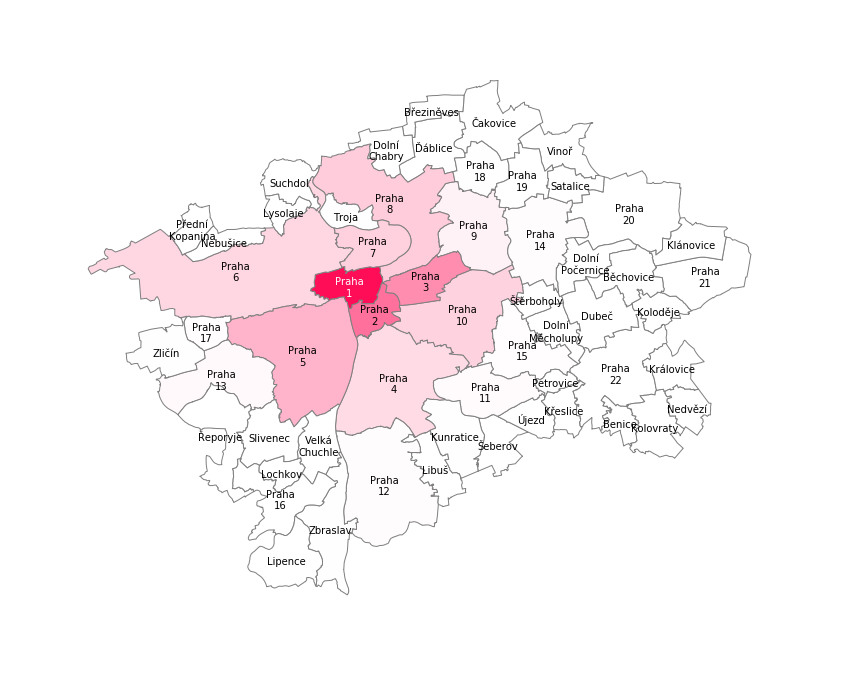

In [10]:
ax = gplt.choropleth(df_geo, 
                     projection=gcrs.EuroPP(),
                     hue = df_geo['ratio'],
                     cmap = pinks,
                     edgecolor='grey',
                     linewidth=1,
                     figsize=(15, 15))
for i, item in df_geo.to_crs('EPSG:25832').centroid.iteritems():
        ax.annotate(s=df_geo.iloc[i]['neighbourhood'].replace(' ', '\n'), 
            xy=[item.x, item.y], 
            color= 'black' if not (df_geo.iloc[i]['neighbourhood'] == 'Praha 1') else 'white', 
            horizontalalignment='center',
            verticalalignment='center')

## Kernel density estimation plot of indivudual listings

/opt/conda/lib/python3.7/site-packages/geoplot/geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None


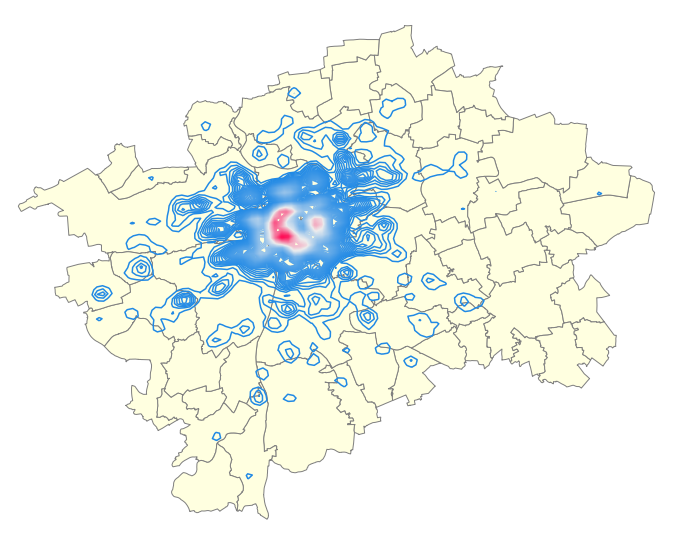

In [11]:
ax2 = gplt.polyplot(df_geo, 
                     projection=gcrs.EuroPP(),
                     edgecolor='grey', facecolor='lightyellow', linewidth=1, figsize=(12, 12))

gplt.kdeplot(points, n_levels=200, cmap = cmap, projection=gcrs.EuroPP(), extent = df_geo.total_bounds, ax = ax2)
plt.show()

## Individual listings represented by each dot, colour coded by the time it takes to travel to the city centre by public transport

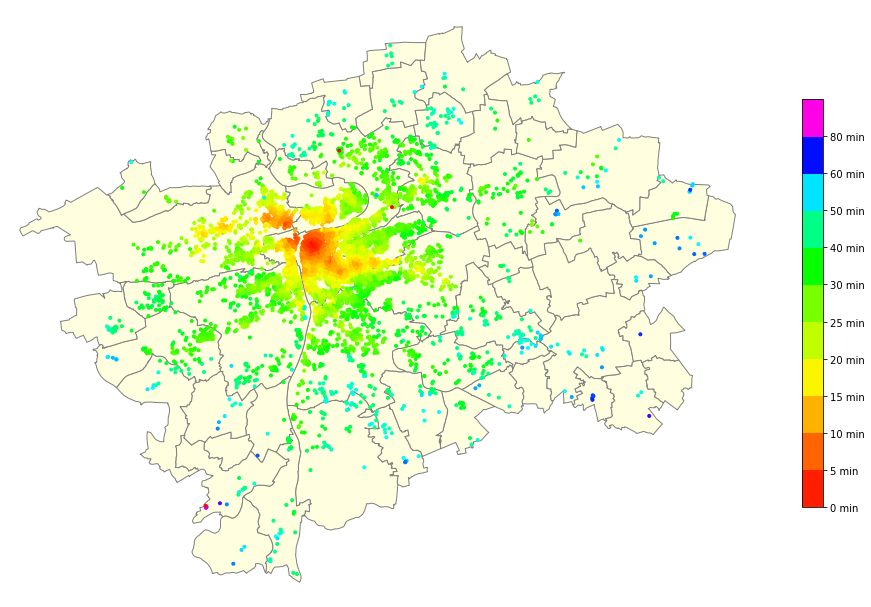

In [17]:
ax = gplt.polyplot(df_geo, 
                    projection=gcrs.EuroPP(),
                    edgecolor='grey', 
                    facecolor='lightyellow', 
                    linewidth=1, 
                    figsize=(15, 15))
gplt.pointplot(points, hue='centre_transit_time', 
               projection=gcrs.EuroPP(), 
               extent = df_geo.total_bounds, 
               cmap='hsv',
               scale = 'centre_transit_time',
               limits=(3, 3),
               legend = True,
               legend_var='hue',
               legend_kwargs= {'shrink': 0.5, 
                               'fraction': 0.05, 
                               'pad': 0.05,
                               'format': '%.0f min',
                               'ticks': [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80],
                               'boundaries': [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100]
                              },
               ax = ax)

## Boroughs colour coded by the amount of time it takes to the city centre by public transport (average of its listings)

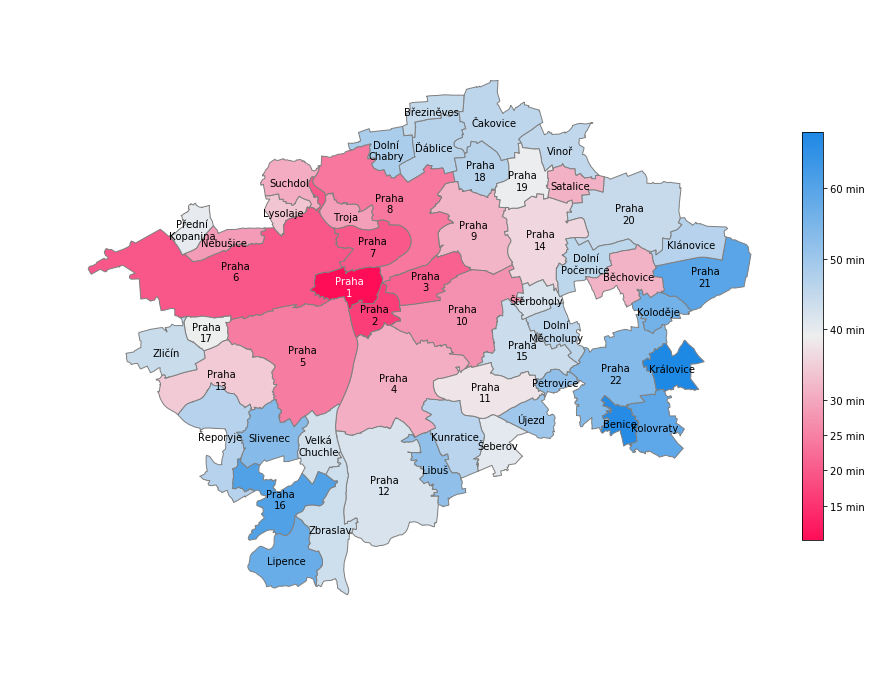

In [13]:
df_geo_nn = df_geo[df_geo['centre_transit_time'].notnull()]
ax = gplt.choropleth(df_geo_nn, 
                     projection=gcrs.EuroPP(),
                     hue = df_geo_nn['centre_transit_time'],
                     cmap = cmap_r,
                     edgecolor='grey', 
                     linewidth=1,
                     legend = True,
                     legend_kwargs= {'shrink': 0.5, 
                                     'fraction': 0.05, 
                                     'pad': -0.05,
                                     'format': '%.0f min',
                                     'ticks': [0, 1, 10, 15, 20, 25, 30, 40, 50, 60]},
                     figsize=(15, 15))
for i, item in df_geo.to_crs('EPSG:25832').centroid.iteritems():
    if not (np.isnan(df_geo.iloc[i]['centre_transit_time'])):
        ax.annotate(s=df_geo.iloc[i]['neighbourhood'].replace(' ', '\n'), 
                    xy=[item.x, item.y], 
                    color= 'black' if not (df_geo.iloc[i]['neighbourhood'] == 'Praha 1') else 'white',
                    horizontalalignment='center',
                    verticalalignment='center')